# 实战案例：基于交叉注意力的跨模态检索

- 基于对应表示的模型VSE++建模了图文整体表示之间的关联
- 基于交叉注意力的跨模态检索模型SCAN建模了图文更细粒度的局部表示之间的关联。


## 模型训练流程

![模型训练的一般流程](img/cr-traning_process.png)



## 读取数据

和VSE++相同，使用flickr8k作为实验数据集，需要先按照vse++的整理数据方式对数据进行整理。 
- VSE++中已经介绍了其下载方式、划分方法。


### 提取图像区域表示

数据集下载完成后，我们需要使用[bottom up attention模型](https://github.com/peteanderson80/bottom-up-attention)提取图像区域表示。具体而言，我们对每张图片提取36个检测框特征。安装配置好代码环境后，

- 将脚本tools/generate_tsv.py 里的 MIN_BOXES 和 MAX_BOXES 值均设置为36，并在load_image_ids函数里增加flickr8k数据集的信息：
```python
elif split_name == 'flickr8k':
    data_dir = '../data/flickr8k/'
    with open(os.path.join(data_dir, 'dataset_flickr8k.json'), 'r') as j:
        data = json.load(j)
    for img in data['images']:
        split.append((os.path.join(data_dir, 'images', img['filename']), img['imgid']))
```
- 使用下面的命令抽取图片表征（注意根据自己机器的配置更改gpu信息）：
```
./tools/generate_tsv.py --gpu 0,1,2,3 \
    --cfg  experiments/cfgs/faster_rcnn_end2end_resnet.yml \
    --def models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt \
    --out resnet101_faster_rcnn_flickr8k.tsv \
    --net data/faster_rcnn_models/resnet101_faster_rcnn_final.caffemodel \
    --split flickr8k 
```
- 调用脚本里的merge_tsvs函数，合并多个gpu的图像特征文件，并将结果拷贝至config的data_dir目录下。

- 解析抽取的图像特征文件，将每张图片的36个检测框特征存储为单个npy格式文件，并将文件路径记录在数据json文件中。
  - 为了后续的数据分析，将检测框的位置信息也以npy格式存储。
  - json文件中的路径仅存储文件名前缀，加上后缀'.npy'为图像特征，加上后缀'.box.npy'为检测框特征。

In [1]:
%matplotlib inline
import base64
import csv
import json
import numpy as np
import os
import sys
from PIL import Image
from matplotlib import pyplot as plt

csv.field_size_limit(sys.maxsize)

def resort_image_feature(dataset='flickr8k'):
    karpathy_json_path = '../data/%s/dataset_flickr8k.json' % dataset
    image_feature_path = '../data/%s/bottom_up_feature.tsv' % dataset
    feature_folder = '../data/%s/image_box_features' % dataset
    if not os.path.exists(feature_folder):
        os.mkdir(feature_folder)

    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)
    img_id2filename = {img['imgid']:img['filename'] for img in data['images']}
        
    imgid2feature = {}
    imgid2box = {}
    FIELDNAMES = ['image_id', 'image_h', 'image_w', 'num_boxes', 'boxes', 'features']
    with open(image_feature_path, 'r') as tsv_in_file:
        reader = csv.DictReader(tsv_in_file, delimiter='\t', fieldnames = FIELDNAMES)
        for item in reader:
            item['image_id'] = int(item['image_id'])
            item['image_h'] = int(item['image_h'])
            item['image_w'] = int(item['image_w'])
            item['num_boxes'] = int(item['num_boxes'])
            for field in ['boxes', 'features']:
                buf = base64.b64decode(item[field])
                temp = np.frombuffer(buf, dtype=np.float32)
                item[field] = temp.reshape((item['num_boxes'],-1))
            
            imgid2feature[item['image_id']] = item['features']
            imgid2box[item['image_id']] = item['boxes']
            
            np.save(os.path.join(feature_folder, img_id2filename[item['image_id']]+'.npy'), item['features'])
            np.save(os.path.join(feature_folder, img_id2filename[item['image_id']]+'.box.npy'), item['boxes'])

resort_image_feature()

在调用该函数生成需要的格式的数据集文件之后，我们可以展示其中一条数据，简单验证下数据的格式是否和我们预想的一致。

<start> a black dog is looking through the fence <end>
<start> a dark brown dog is running along a fence outside <end>
<start> a brown dog runs along a fence <end>
<start> the brown greyhound dog walks on green grass and looks through a fence <end>
<start> a large black dog runs along a fence in the grass <end>


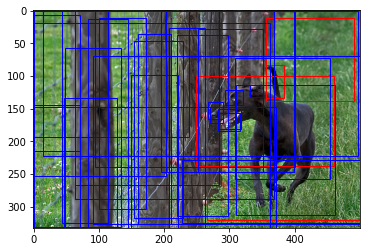

In [2]:
# 读取词典和验证集
with open('../data/flickr8k/vocab.json', 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}
with open('../data/flickr8k/val_data.json', 'r') as f:
    data = json.load(f)

# 展示第20张图片和36个区域，其对应的文本描述序号是100到104
content_img = Image.open(data['IMAGES'][20])
for i in range(5):
    print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][20*5+i]]))

fig = plt.imshow(content_img)
feats = np.load(data['IMAGES'][20].replace('images','image_box_features')+'.box.npy')
for i in range(feats.shape[0]):
    bbox = feats[i,:]
    color = 'red'
    if i > 3:
        color = 'blue'
    fig.axes.add_patch(plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=1))
    

### 定义数据集类

按照惯例，在准备好的数据集的基础上，我们需要进一步定义PyTorch Dataset类，以使用PyTorch DataLoader类按批次产生数据。
- 具体方法还是继承torch.utils.data.Dataset类，并实现__getitem__和__len__两个函数。

In [3]:
from argparse import Namespace 
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

class ImageBoxTextDataset(Dataset):
    """
    PyTorch数据类，用于PyTorch DataLoader来按批次产生数据
    """

    def __init__(self, dataset_path, vocab_path, split, captions_per_image=5, max_len=30):
        """
        参数：
            dataset_path：json格式数据文件路径
            vocab_path：json格式词典文件路径
            split：train、val、test
            captions_per_image：每张图片对应的文本描述数
            max_len：文本描述包含的最大单词数
        """
        self.split = split
        assert self.split in {'train', 'val', 'test'}
        self.cpi = captions_per_image
        self.max_len = max_len
        # 载入数据集
        with open(dataset_path, 'r') as f:
            self.data = json.load(f)
        # 载入词典
        with open(vocab_path, 'r') as f:
            self.vocab = json.load(f)

        # Total number of datapoints
        self.dataset_size = len(self.data['CAPTIONS'])

    def __getitem__(self, i):
        # 第i个文本描述对应第(i // captions_per_image)张图片
        img = torch.Tensor(np.load(self.data['IMAGES'][i // self.cpi].replace('images','image_box_features')+'.npy'))
        caplen = len(self.data['CAPTIONS'][i])
        caption = torch.LongTensor(self.data['CAPTIONS'][i]+ [self.vocab['<pad>']] * (self.max_len + 2 - caplen))

        return img, caption, caplen
        

    def __len__(self):
        return self.dataset_size

### 批量读取数据

利用刚才构造的数据集类，借助DataLoader类构建能够按批次产生训练、验证和测试数据的对象。
- 这里由于图像表示是预先提取的，因此不再需要对图像数据进行增强操作。

In [4]:
def mktrainval(data_dir, vocab_path, batch_size, workers=4):    
    train_set = ImageBoxTextDataset(os.path.join(data_dir, 'train_data.json'), 
                                    vocab_path, 'train')
    valid_set = ImageBoxTextDataset(os.path.join(data_dir, 'val_data.json'), 
                                    vocab_path, 'val')
    test_set = ImageBoxTextDataset(os.path.join(data_dir, 'test_data.json'), 
                                   vocab_path, 'test')

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, valid_loader, test_loader    


## 定义模型

SCAN模型是由图像表示提取器和文本表示提取器构成，二者提取图像中的每个区域和文本中的每个词的表示。


### 图像表示提取器

在图像特征基础上增加一个全连接层，以输出符合对应表示空间维度的图像编码。
- 图像区域输入特征的形状为(batch_size, 36, 2048)。由于PyTorch中的全连接层实现nn.Linear默认对最后一个维度执行变换，因此，这里并不需要对输入特征的形状进行特殊的处理。
- 需要注意的是，这里也对图像表示进行了长度归一化，归一化时需要指定维度。

In [5]:
class ImageRepExtractor(nn.Module):
    def __init__(self, img_feat_dim, embed_size):
        super(ImageRepExtractor, self).__init__()
        self.fc = nn.Linear(img_feat_dim, embed_size)
        
    def forward(self, x):
        out = self.fc(x)
        out = nn.functional.normalize(out, dim=-1)
        return out


### 文本表示提取器

SCAN模型使用双向GRU模型作为文本表示提取器，它的输入层为词嵌入形式，词的表示为其对应的前向和后向的最后一个隐藏层输出的平均值。
- 词表示的维度也进行了长度归一化。

In [6]:
class TextRepExtractor(nn.Module):
    def __init__(self, vocab_size, word_dim, embed_size, num_layers):
        super(TextRepExtractor, self).__init__()
        self.embed_size = embed_size
        self.embed = nn.Embedding(vocab_size, word_dim)
        self.rnn = nn.GRU(word_dim, embed_size, num_layers, batch_first=True, bidirectional=True)

        self.init_weights()
    
    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)

    def forward(self, x, lengths):
        x = self.embed(x)
        packed = pack_padded_sequence(x, lengths, batch_first=True) # 压缩掉填充值
        out, _ = self.rnn(packed)
        padded = pad_packed_sequence(out, batch_first=True) # 填充回来

        # 双向RNN，隐藏层的最后一个维度的大小为2*embed_size，每个词的表示为(正向+后向)/ 2
        # 注意：句子长度会减少到x中最长的句子的长度
        cap_emb, _ = padded
        cap_emb = (cap_emb[:,:,:cap_emb.size(2)//2] + cap_emb[:,:,cap_emb.size(2)//2:])/2

        out = nn.functional.normalize(cap_emb, dim=-1)
        return out

### SCAN模型
和VSE++模型一样，有了图像表示提取器和文本表示提取器，我们就可以构建SCAN模型了。
- 这里同样需要注意要先按照文本的长短对数据进行排序，且为了评测模型时能够对齐图像和文本数据，我们需要恢复数据原始的输入顺序。

In [7]:
class SCAN(nn.Module):
    def __init__(self, vocab_size, word_dim, embed_size, num_layers, img_feat_dim):
        super(SCAN, self).__init__()
        self.image_encoder = ImageRepExtractor(img_feat_dim, embed_size)
        self.text_encoder = TextRepExtractor(vocab_size, word_dim, embed_size, num_layers)
        
    def forward(self, images, captions, cap_lens):
        # 按照caption的长短排序，并对照调整image的顺序
        sorted_cap_lens, sorted_cap_indices = torch.sort(cap_lens, 0, True)
        images = images[sorted_cap_indices]
        captions = captions[sorted_cap_indices]
        cap_lens = sorted_cap_lens

        image_code = self.image_encoder(images)
        text_code = self.text_encoder(captions, cap_lens)
        if not self.training:
            # 恢复数据原始的输入顺序
            _, recover_indices = torch.sort(sorted_cap_indices)
            image_code = image_code[recover_indices]
            text_code = text_code[recover_indices]
        return image_code, text_code

## 定义损失函数
和VSE++模型一样，SCAN模型也采用了在线挖掘困难样本的triplet损失函数。二者的不同之处在于图像和文本相关分数的计算方式。

SCAN模型使用的是基于交叉注意力的相关性计算方法。

- 首先利用交叉注意力计算图像或文本经过跨模态对齐之后的局部表示
- 然后计算对齐前后局部表示之间的余弦相似度
- 最后再使用累积函数综合局部相似度求得图文具体的匹配得分

SCAN模型尝试了以图像为查询和以文本为查询的两种形式的交叉注意力，下面将首先介绍通用注意力函数的实现，然后分别介绍这两种形式的交叉注意力。本部分代码的实现参照了SCAN模型的作者发布的[源码](https://github.com/kuanghuei/SCAN)。


### 注意力函数

不管是以图像为查询还是以文本为查询，我们首先都需要实现一个通用的计算注意力的函数。通用的注意力函数利用三个输入Q、K和V，输出可以理解为用V表示Q的结果。具体实现上，该函数包含三个步骤：
- 选取Q和K的关联方式并计算注意力相关性分数；
- 归一化Q和K的相关性分数；
- 以相关性分数作为V的权重，计算输出。

在跨模态注意力中，Q是一个模态，K和V是另一个模态。


In [8]:
def func_attention(query, key_value, smooth, func_attn_score='plain'):
    """
    Q K V：Q和K算出相关性得分，作为V的权重，K=V
    参数：
        query: 查询 (batch_size, n_query, d)
        key_value: 键和值，(batch_size, n_kv, d)
    """
    batch_size, n_query = query.size(0), query.size(1)
    n_kv = key_value.size(1)

    # （2）计算query和key的相关性，实现a函数
    # query^T: (batch_size, d, n_query)
    queryT = torch.transpose(query, 1, 2)
    # (batch_size, n_kv, d)(batch_size, d, n_query)
    # => attn: (batch_size, n_kv, n_query)
    attn = torch.bmm(key_value, queryT)
    if func_attn_score == "plain":
        pass
    elif func_attn_score == "softmax":
        attn = nn.Softmax(dim=2)(attn)
    elif func_attn_score == "l2norm":
        attn = nn.functional.normalize(attn, dim=2)
    elif func_attn_score == "clipped":
        attn = nn.LeakyReLU(0.1)(attn)
    elif func_attn_score == "clipped_l2norm":
        attn = nn.LeakyReLU(0.1)(attn)
        attn = nn.functional.normalize(attn, dim=2)
    else:
        raise ValueError("unknown function for attention score:", func_attn_score)
    # （3）归一化相关性分数
    # (batch_size, n_query, n_kv)
    attn = torch.transpose(attn, 1, 2).contiguous()
    # (batch_size*n_query, n_kv)
    attn = attn.view(batch_size*n_query, n_kv)
    attn = nn.Softmax(dim=1)(attn*smooth)
    # (batch_size, n_query, n_kv)
    attn = attn.view(batch_size, n_query, n_kv)
    # (batch_size, n_kv, n_query)
    attnT = torch.transpose(attn, 1, 2).contiguous()
    # （4）计算输出
    # (batch_size, d, n_kv)
    key_valueT = torch.transpose(key_value, 1, 2)
    # (batch_size x d x n_kv)(batch_size x n_kv x n_query)
    # => (batch_size, d, n_query)
    output = torch.bmm(key_valueT, attnT)
    # --> (batch_size, n_query, d)
    output = torch.transpose(output, 1, 2)

    return output, attnT

### 交叉注意力 

SCAN模型尝试了两种形式的交叉注意力：图像-文本交叉注意力和文本-图像注意力。
- 图像-文本跨模态注意力是以图像模态为查询，文本模态为键和值的交叉注意力。
- 文本-图像跨模态注意力是以文本模态为查询，图像模态为键和值的交叉注意力。

对于交叉注意力计算过程中涉及的累积函数，SCAN模型也尝试了两种形式：
- 平均值函数；
- 可看作平滑max函数的LogSumExp函数。
  - 这里实际使用的是带超参数$\lambda_{lse}$的LogSumExp函数，即$\rm log(\sum_{i=1}^n e^{\lambda_{lse}x_i})/\lambda_{lse}$。$\rm \lambda_{lse}$可以控制函数的精确程度，显然，由于指数函数越到后面变化幅度越大，因此$\rm \lambda_{lse}$取值越大，LogSumExp越逼近max函数，$\rm \lambda_{lse}$取值越小，LogSumExp越平滑。

下面的函数给出了交叉注意力的具体实现。

In [9]:
def xattn_score(images, captions, cap_lens, config):
    """
    参数：
        Images: (batch_size, n_regions, d) 
        Captions: (batch_size, max_n_words, d)
        CapLens: (batch_size) array of caption lengths
    """
    similarities = []
    n_image = images.size(0)
    n_caption = captions.size(0)
    for i in range(n_caption):
        # 获得第i条文本描述
        n_word = cap_lens[i]
        cap_i = captions[i, :n_word, :].unsqueeze(0).contiguous()
        # 将第i条文本复制至n_image份 
        # (n_image, n_word, d)
        cap_i_expand = cap_i.repeat(n_image, 1, 1)
        if config.cross_attn == 'i2t':
            """
                图像-文本交叉注意力：用文本中的词来表示图像中的每个区域，所有图片的所有区域用当前文本表示
                images(query): (n_image, n_region, d)
                cap_i_expand(key_value): (n_image, n_word, d)
                align_feature: (n_image, n_region, d)
            """
            align_feature, _ = func_attention(images, cap_i_expand, config.lambda_softmax, config.func_attn_score)
            # 当前文本和图片的相关度
            # (n_image, n_region)
            row_sim = nn.functional.cosine_similarity(images, align_feature, dim=2)
        elif config.cross_attn == 't2i':
            """
                文本-图像交叉注意力：用图像表示文本中的每个词，当前文本中的词用所有图片来表示
                cap_i_expand(query): (n_image, n_word, d)
                images(key_value): (n_image, n_regions, d)
                align_feature: (n_image, n_word, d)
            """
            align_feature, _ = func_attention(cap_i_expand, images, config.lambda_softmax, config.func_attn_score)
            # 当前文本和图片的相关度
            # (n_image, n_word)
            row_sim = nn.functional.cosine_similarity(cap_i_expand, align_feature, dim=2)
        else:
            raise ValueError("unknown cross attention type: {}".format(config.cross_attn))
        # 累计函数
        if config.agg_func == 'LSE':
            row_sim = torch.logsumexp(row_sim.mul_(config.lambda_lse), dim=1, keepdim=True) / config.lambda_lse
        elif config.agg_func == 'AVG':
            row_sim = row_sim.mean(dim=1, keepdim=True)
        else:
            raise ValueError("unknown aggfunc: {}".format(config.agg_func))
        similarities.append(row_sim)

    # (n_image, n_caption)
    similarities = torch.cat(similarities, 1)
    return similarities

### 困难样本挖掘的triplet损失函数

和VSE++模型中使用的损失函数的唯一区别在于图文关联分数的计算采用了交叉注意力方法。

In [10]:
class XAttnTripletNetLoss(nn.Module):
    def __init__(self, config, margin=0.2, hard_negative=False):
        super(XAttnTripletNetLoss, self).__init__()
        self.config = config
        self.margin = margin
        self.hard_negative = hard_negative

    def forward(self, ie, te, tl):
        # 和vse++模型唯一的区别在于图文关联分数的计算
        scores = xattn_score(ie, te, tl, self.config)
        diagonal = scores.diag().view(ie.size(0), 1)
        d1 = diagonal.expand_as(scores)
        d2 = diagonal.t().expand_as(scores)

        # 图像为锚
        cost_i = (self.margin + scores - d1).clamp(min=0)
        # 文本为锚
        cost_t = (self.margin + scores - d2).clamp(min=0)

        mask = torch.eye(scores.size(0), dtype=torch.bool)
        I =  torch.autograd.Variable(mask)
        if torch.cuda.is_available():
            I = I.cuda()
        cost_i = cost_i.masked_fill_(I, 0)
        cost_t = cost_t.masked_fill_(I, 0)

        # 找困难样本
        if self.hard_negative:
            cost_i = cost_i.max(1)[0]
            cost_t = cost_t.max(0)[0]

        return cost_i.sum() + cost_t.sum()

## 选择优化方法

这里选用Adam优化算法来更新模型参数，学习速率采用分段衰减方法。

In [11]:
def get_optimizer(model, config):
    return torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate)
    
def adjust_learning_rate(optimizer, epoch, config):
    """每隔lr_update个轮次，学习速率减小至当前十分之一"""
    lr = config.learning_rate * (0.1 ** (epoch // config.lr_update))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## 评估指标
这里同样使用跨模态检索中最常用的评估指标Recall@K。

- 首先利用SCAN模型计算图像和文本编码
- 然后直接计算所有图像编码和所有文本编码之间的相似度得分
- 最后利用得分排序计算Recall@K

需要注意的是，这里的图文编码间的相似度得分是基于交叉注意力计算得到的，计算复杂度较高，需要在GPU上执行。然而，GPU无法一次性存储所有的测试数据，因此，我们需要分块计算相似度得分，具体实现细节见函数calc_score。

In [12]:
import math

def evaluate(data_loader, model, batch_size, config):
    # 模型切换进入评估模式
    model.eval()
    device = next(model.parameters()).device
    max_len = config.max_len + 2
    image_codes = torch.zeros((len(data_loader.dataset), config.max_boxes, config.embed_size))
    text_codes = torch.zeros((len(data_loader.dataset), max_len, config.embed_size))
    cap_lens = []
    
    for i, (imgs, caps, caplens) in enumerate(data_loader):
        with torch.no_grad():
            image_code, text_code = model(imgs.to(device), caps.to(device), caplens)
            # 将图文对应表示存到numpy数组中，gpu一般无法存储全部数据，因此先存储至系统内存中
            image_codes[i*batch_size:(i+1)*batch_size] = image_code.data.cpu()
            text_codes[i*batch_size:(i+1)*batch_size,:text_code.size(1),:] = text_code.data.cpu()
            cap_lens.extend(caplens)
    res = calc_recall(image_codes, text_codes, cap_lens, config)
    # 模型切换回训练模式
    model.train()
    return res

def calc_score(image_codes, text_codes, cap_lens, config):
    # 分块计算图文相似度得分，这里，每次计算500张图片和1000条文本的相似度得分
    image_bs = 500
    text_bs = 1000
    image_num = image_codes.size(0)
    text_num = text_codes.size(0)
    n_image_batch = math.ceil(image_num / float(image_bs))
    n_text_batch = math.ceil(text_num / float(text_bs))
    scores = []
    for i in range(n_text_batch):
        text_code = text_codes[i*text_bs:min((i+1)*text_bs,text_num)].cuda()
        tmp_scores = []
        for j in range(n_image_batch):
            image_code = image_codes[j*image_bs:min((j+1)*image_bs,image_num)].cuda()
            tmp_scores.append(xattn_score(image_code, text_code, cap_lens, config))
        # n_text_batch个(image_bs, text_bs)矩阵块，拼接成矩阵(image_num, text_bs)
        # 最终是在cpu上计算recall
        scores.append(torch.cat(tmp_scores, 0).cpu())
    scores = torch.cat(scores, 1).numpy()
    return scores

def calc_recall(image_codes, text_codes, cap_lens, config): 
    # 之所以可以每隔固定数量取图片，是因为前面对图文数据对输入顺序进行了还原
    cpi = config.captions_per_image
    image_codes = image_codes[::cpi]
    scores = calc_score(image_codes, text_codes, cap_lens, config)
     # 以图检文：按行从大到小排序
    sorted_scores_indices = (-scores).argsort(axis=1)
    (n_image, n_text) = scores.shape
    ranks_i2t = np.zeros(n_image)
    for i in range(n_image):
         # 一张图片对应cpi条文本，找到排名最高前的文本位置
        min_rank = 1e10
        for j in range(i*cpi,(i+1)*cpi):
            rank = list(sorted_scores_indices[i,:]).index(j)
            if min_rank > rank:
                min_rank = rank
        ranks_i2t[i] = min_rank
    # 以文检图：按列从大到小排序
    sorted_scores_indices = (-scores).argsort(axis=0)
    ranks_t2i = np.zeros(n_text)
    for i in range(n_text):
        rank = list(sorted_scores_indices[:,i]).index(i//cpi)
        ranks_t2i[i] = rank
    # 最靠前的位置小于k，即为recall@k
    r1_i2t = 100.0 * len(np.where(ranks_i2t<1)[0]) / n_image
    r1_t2i = 100.0 * len(np.where(ranks_t2i<1)[0]) / n_text
    r5_i2t = 100.0 * len(np.where(ranks_i2t<5)[0]) / n_image
    r5_t2i = 100.0 * len(np.where(ranks_t2i<5)[0]) / n_text
    r10_i2t = 100.0 * len(np.where(ranks_i2t<10)[0]) / n_image
    r10_t2i = 100.0 * len(np.where(ranks_t2i<10)[0]) / n_text
    return r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i


## 训练模型

和VSE++模型一样，训练模型过程还是分为读取数据、前馈计算、计算损失、更新参数、选择模型五个步骤。

In [ ]:
config = Namespace(
    captions_per_image = 5,
    max_len = 30,
    max_boxes = 36,
    batch_size = 128,
    word_dim = 300,
    embed_size = 1024,
    num_layers = 1,
    img_feat_dim = 2048,
    learning_rate = 0.0005,
    lr_update = 10,
    margin = 0.2,
    hard_negative = True,
    num_epochs = 30,
    grad_clip = 2,
    evaluate_step = 60,
    checkpoint = None,
    best_checkpoint = '../model/scan/best_flickr8k.pth.tar',
    last_checkpoint = '../model/scan/last_flickr8k.pth.tar',
    func_attn_score = 'clipped_l2norm', # plain|softmax|clipped|l2norm|clipped_l2norm
    agg_func = 'LSE', # LSE|AVG
    cross_attn = 't2i', # t2i|i2t
    lambda_lse = 6,
    lambda_softmax = 9
)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# 数据
data_dir = '../data/flickr8k/'
vocab_path = '../data/flickr8k/vocab.json'
train_loader, valid_loader, test_loader = mktrainval(data_dir, 
                                                     vocab_path, 
                                                     config.batch_size)
# 模型
with open(vocab_path, 'r') as f:
    vocab = json.load(f)
model = SCAN(len(vocab), config.word_dim, config.embed_size, config.num_layers, config.img_feat_dim)
model.to(device)
model.train()

# 损失函数
loss_fn = XAttnTripletNetLoss(config, config.margin, True)

# 优化器
optimizer = get_optimizer(model, config)
    
start_epoch = 0
best_res = 0
print("开始训练！")
for epoch in range(start_epoch, config.num_epochs):
    adjust_learning_rate(optimizer, epoch, config)
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        optimizer.zero_grad()

        imgs = imgs.to(device)
        caps = caps.to(device)

        image_code, text_code = model(imgs, caps, caplens)
        loss = loss_fn(image_code, text_code, caplens)
        loss.backward()
        
        # 梯度截断
        if config.grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)

        optimizer.step()

        state = {
            'epoch': epoch,
            'step': i,
            'model': model,
            'optimizer': optimizer
        }
        
        if (i+1) % config.evaluate_step == 0:
            r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i = evaluate(valid_loader, model, config.batch_size, config)
            recall_sum = r1_i2t + r1_t2i + r5_i2t + r5_t2i + r10_i2t + r10_t2i
            if best_res < recall_sum:
                best_res = recall_sum
                torch.save(state, config.best_checkpoint)
            torch.save(state, config.last_checkpoint)
            print('''epoch: %d, step: %d, loss: %.2f, 
                  I2T R@1: %.2f, T2I R@1: %.2f,  
                  I2T R@5: %.2f, T2I R@5: %.2f, 
                  I2T R@10: %.2f, T2I R@10: %.2f,''' % 
                  (epoch, i+1, loss.item(), r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i))
            
checkpoint = torch.load(config.best_checkpoint)
model = checkpoint['model']
r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i = evaluate(test_loader, model, config.batch_size, config)
print("Evaluate on the test set with the model that has the best performance on the validation set")
print('Epoch: %d, \
      I2T R@1: %.2f, T2I R@1: %.2f, \
      I2T R@5: %.2f, T2I R@5: %.2f, \
      I2T R@10: %.2f, T2I R@10: %.2f' % 
      (checkpoint['epoch'], r1_i2t, r1_t2i, r5_i2t, r5_t2i, r10_i2t, r10_t2i))
    

这段代码完成训练，最后一行会输出在验证集上表现最好的模型在测试集上的结果，具体如下：
```
Epoch: 26, I2T R@1: 41.60, T2I R@1: 29.56,  I2T R@5: 71.30, T2I R@5: 59.34, I2T R@10: 82.90, T2I R@10: 72.24
```

和之前实现的VSE++模型相比，SCAN模型在跨模态检索任务上的表现更优。在以图检文和以文检图任务上，
- SCAN模型分别获得了41.6和29.56的Recall@1值；
- VSE++模型获得的Recall@1值分别为22.20和17.30。